# California Housing Price Analysis
## CS 133 Team Project - Data Engineering Artifacts

**Team Members:** Sidharth Krishnaswamy, Rayhann Kwon, Arthur Wong, Andrian Than  
**Professor:** Jelena Gligorijevic

This notebook demonstrates all required data engineering artifacts:
- **Artifact A:** Data Card documentation **(UPDATED)**
- **Artifact B:** Dataset transformation with new columns and missing data handling **(UPDATED)**
- **Artifact C:** Structural Figures (Seaborn)
- **Artifact D:** Statistical Check UPDATED
- **Artifact E:** Reproducible analysis in a single notebook

In [8]:
#Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency
from sklearn.datasets import fetch_california_housing
import warnings
warnings.filterwarnings('ignore')

#Plotting style
plt.style.use('default')
sns.set_palette("husl")


## Data Loading


In [9]:
# Load Dataset
california_housing = fetch_california_housing(as_frame=True)
df = california_housing.frame

# Rename columns for clarity
feature_names = {
    'MedInc': 'median_income',
    'HouseAge': 'housing_median_age',
    'AveRooms': 'avg_rooms',
    'AveBedrms': 'avg_bedrooms',
    'Population': 'population',
    'AveOccup': 'avg_occupancy',
    'Latitude': 'latitude',
    'Longitude': 'longitude',
    'MedHouseVal': 'median_house_value'
}

df = df.rename(columns=feature_names)
df.head()


,median_income,housing_median_age,avg_rooms,avg_bedrooms,population,avg_occupancy,latitude,longitude,median_house_value
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422


# Artifact A: Data Card

Comprehensive documentation of dataset properties, source, and characteristics.

In [10]:
print("=" * 60)
print("ARTIFACT A: DATA CARD")
print("=" * 60)

print(f"""
Dataset: California Housing Prices (1990 Census)
Source: Scikit-learn datasets (originally from US Census Bureau)
Shape: {df.shape[0]:,} rows x {df.shape[1]} columns
Time Range: 1990 Census data
Coverage: California, USA

COLUMN DIRECTORY:
""")

# Column descriptions with units and ranges
column_info = {
    'median_income': 'Median household income (in tens of thousands of dollars)',
    'housing_median_age': 'Median age of houses in block group (years)',
    'avg_rooms': 'Average number of rooms per household',
    'avg_bedrooms': 'Average number of bedrooms per household',
    'population': 'Total population in block group (persons)',
    'avg_occupancy': 'Average household size (persons per household)',
    'latitude': 'Latitude coordinate (degrees)',
    'longitude': 'Longitude coordinate (degrees)',
    'median_house_value': 'Median house value (hundreds of thousands of dollars)'
}

for col, desc in column_info.items():
    if col in df.columns:
        print(f"- {col}: {desc}")
        print(f"  {'Range'}: {df[col].min():.3f} to {df[col].max():.3f}")
        print()

# Key targets and features
print("KEY COLUMNS:")
print("- Target Variable: median_house_value")
print("- Geographic Features: latitude, longitude")
print("- Economic Features: median_income")
print("- Housing Features: housing_median_age, avg_rooms, avg_bedrooms, avg_occupancy")
print("- Demographic Features: population")

ARTIFACT A: DATA CARD

Dataset: California Housing Prices (1990 Census)
Source: Scikit-learn datasets (originally from US Census Bureau)
Shape: 20,640 rows x 9 columns
Time Range: 1990 Census data
Coverage: California, USA

COLUMN DIRECTORY:

- median_income: Median household income (in tens of thousands of dollars)
  Range: 0.500 to 15.000

- housing_median_age: Median age of houses in block group (years)
  Range: 1.000 to 52.000

- avg_rooms: Average number of rooms per household
  Range: 0.846 to 141.909

- avg_bedrooms: Average number of bedrooms per household
  Range: 0.333 to 34.067

- population: Total population in block group (persons)
  Range: 3.000 to 35682.000

- avg_occupancy: Average household size (persons per household)
  Range: 0.692 to 1243.333

- latitude: Latitude coordinate (degrees)
  Range: 32.540 to 41.950

- longitude: Longitude coordinate (degrees)
  Range: -124.350 to -114.310

- median_house_value: Median house value (hundreds of thousands of dollars)
  Rang

In [11]:
#Missing Data Snapshot
print(f"\nMISSING DATA SNAPSHOT:")
missing_counts = df.isnull().sum()
missing_pct = (missing_counts / len(df)) * 100

if missing_counts.sum() == 0:
    print("No missing values found in dataset")
else:
    print("Missing values by column:")
    for col in df.columns:
        if missing_counts[col] > 0:
            print(f"• {col}: {missing_counts[col]:,} missing ({missing_pct[col]:.2f}%)")

#Data Checks Summary
print(f"\nDATA CHECK SUMMARY:")
print(f"- Duplicate rows: {df.duplicated().sum():,}")
print(f"- Rows with any missing values: {df.isnull().any(axis=1).sum():,}")
print(f"- Data types: {df.dtypes.value_counts().to_dict()}")


MISSING DATA SNAPSHOT:
No missing values found in dataset

DATA CHECK SUMMARY:
- Duplicate rows: 0
- Rows with any missing values: 0
- Data types: {dtype('float64'): 9}


In [12]:
#Data Quirks
print(f"\nDATA QUIRKS:")
print("- House values capped at $500,000")
print("- Geographic clustering - all data from California only")
print("- 1990 data - may not reflect current housing market patterns")
print("- Block group level data - aggregated, not individual house records")
print("- Average rooms/bedrooms may have outliers from institutional properties")


DATA QUIRKS:
- House values capped at $500,000
- Geographic clustering - all data from California only
- 1990 data - may not reflect current housing market patterns
- Block group level data - aggregated, not individual house records
- Average rooms/bedrooms may have outliers from institutional properties


# Artifact B: Dataset Transformation


In [13]:
print("=" * 60)
print("ARTIFACT B: DATASET TRANSFORMATION")
print("=" * 60)

df_transformed = df.copy()

print("1. CREATING BOOLEAN MASK COLUMNS")
print("-" * 40)

df_transformed['is_coastal'] = (df['longitude'] > -121.5) & (df['latitude'] < 37.5)
coastal_count = df_transformed['is_coastal'].sum()
print(f"is_coastal: Properties likely near coast ({coastal_count:,} properties, {coastal_count/len(df)*100:.2f}%)")

high_income_threshold = df['median_income'].quantile(0.75)
df_transformed['is_high_income_area'] = (df['median_income'] > high_income_threshold)
print(f"is_high_income_area: Areas with income > ${high_income_threshold:.1f}0k ({df_transformed['is_high_income_area'].sum():,} areas, {df_transformed['is_high_income_area'].sum()/len(df)*100:.2f}%)")

df_transformed['aged_house'] = (df['housing_median_age'] > 10)
print(f"aged_house: Areas with houses > 10 years old ({df_transformed['aged_house'].sum():,} areas, {df_transformed['aged_house'].sum()/len(df)*100:.2f}%)")

df_transformed['new_house'] = (df['housing_median_age'] <= 10)
print(f"new_house: Areas with houses < 10 years old ({df_transformed['new_house'].sum():,} areas, {df_transformed['new_house'].sum()/len(df)*100:.2f}%)")

print(f"\nBoolean flag summary:")
boolean_cols = ['is_coastal', 'is_high_income_area', 'aged_house', 'new_house']
for col in boolean_cols:
    true_count = df_transformed[col].sum()
    print(f"  {col:20}: {true_count:5,} ({true_count/len(df)*100:4.1f}%)")

ARTIFACT B: DATASET TRANSFORMATION
1. CREATING BOOLEAN MASK COLUMNS
----------------------------------------
is_coastal: Properties likely near coast (12,971 properties, 62.84%)
is_high_income_area: Areas with income > $4.70k (5,160 areas, 25.00%)
aged_house: Areas with houses > 10 years old (19,071 areas, 92.40%)
new_house: Areas with houses < 10 years old (1,569 areas, 7.60%)

Boolean flag summary:
  is_coastal          : 12,971 (62.8%)
  is_high_income_area : 5,160 (25.0%)
  aged_house          : 19,071 (92.4%)
  new_house           : 1,569 ( 7.6%)


In [14]:
print("\n2. TRANSFORMATIONS USING MAP() AND APPLY()")
print("-" * 45)

def categorize_income(income):
    """
    Categorize income levels based on 1990 economic standards.
    Ex: 3.0 = $30k
    """
    if income < 3.0:  #less than $30k
        return 'Low'
    elif income < 6.0:  #$30k-$60k
        return 'Medium'
    elif income < 10.0:  #$60k-$100k
        return 'High'
    else:  #over 100k
        return 'Very High'

df_transformed['income_category'] = df_transformed['median_income'].apply(categorize_income)
print(f"income_category: Applied function to categorize income levels")
print(f"Distribution: {df_transformed['income_category'].value_counts()}")

#Create occupancy density using map()
occupancy_mapping = {
    'Low': lambda x: x < 3.0,
    'Medium': lambda x: 3.0 <= x < 4.0,
    'High': lambda x: 4.0 <= x < 5.0,
    'Very High': lambda x: x >= 5.0
}

def map_occupancy_density(occupancy):
    """Map occupancy values to density categories"""
    for category, condition in occupancy_mapping.items():
        if condition(occupancy):
            return category
    return 'Unknown'

df_transformed['occupancy_density'] = df_transformed['avg_occupancy'].map(map_occupancy_density)
print(f"\noccupancy_density: Mapped average occupancy to density levels")
print(f"Distribution: {df_transformed['occupancy_density'].value_counts()}")

#Create region based on latitude and longitude
def get_region(lat, lon):
    if lat > 37.5:
        return "Northern California"
    elif lat < 34.0:
        return "Southern California"
    else:
        return "Central California"

df_transformed['region'] = df_transformed.apply(lambda row: get_region(row['latitude'], row['longitude']), axis=1)

#Create property type based on average amount of rooms
def get_property_type(row):
    if row['avg_rooms'] > 6:
        return "Large Family Home"
    elif row['avg_rooms'] < 4:
        return "Apartment/Condo"
    else:
        return "Standard Home"

df_transformed['property_type'] = df_transformed.apply(lambda row: get_property_type(row), axis=1)

print(f"\nRegion distribution: {df_transformed['region'].value_counts()}")
print(f"\nProperty type distribution: {df_transformed['property_type'].value_counts()}")


2. TRANSFORMATIONS USING MAP() AND APPLY()
---------------------------------------------
income_category: Applied function to categorize income levels
Distribution: income_category
Medium       10902
Low           7365
High          2064
Very High      309
Name: count, dtype: int64

occupancy_density: Mapped average occupancy to density levels
Distribution: occupancy_density
Low          12617
Medium        6273
High          1404
Very High      346
Name: count, dtype: int64

Region distribution: region
Central California     8347
Southern California    6158
Northern California    6135
Name: count, dtype: int64

Property type distribution: property_type
Standard Home        12365
Large Family Home     5407
Apartment/Condo       2868
Name: count, dtype: int64


In [15]:
print("\n3. CATEGORIZING/BUCKETING COLUMNS INTO LEVELS")
print("-" * 48)

# Categorization 1: Age categories using pd.cut() with custom bins
age_bins = [0, 10, 25, 40, 100]
age_labels = ['New', 'Modern', 'Mature', 'Old']
df_transformed['age_category'] = pd.cut(df['housing_median_age'],
                                       bins=age_bins,
                                       labels=age_labels,
                                       include_lowest=True)
print(f"age_category: Bucketed housing age into {len(age_labels)} levels")
print(f"Bins: {age_bins}")
print(f"\nDistribution: {df_transformed['age_category'].value_counts()}")


3. CATEGORIZING/BUCKETING COLUMNS INTO LEVELS
------------------------------------------------
age_category: Bucketed housing age into 4 levels
Bins: [0, 10, 25, 40, 100]

Distribution: age_category
Mature    8132
Modern    7061
Old       3878
New       1569
Name: count, dtype: int64


In [16]:
print("\n4. MISSING DATA HANDLING")
print("-" * 30)

# Check for missing values in original data
original_missing = df.isnull().sum().sum()
print(f"Missing values in original dataset: {original_missing}")

# Decision rationale
print(f"\nMISSING DATA STRATEGY RATIONALE:")
print(f"No missing values in original dataset")
print(f"If there were missing values, we would have filled them with 'Unknown' or dropped them according to the data type")



4. MISSING DATA HANDLING
------------------------------
Missing values in original dataset: 0

MISSING DATA STRATEGY RATIONALE:
No missing values in original dataset
If there were missing values, we would have filled them with 'Unknown' or dropped them according to the data type


In [17]:
print("\n5. CATEOGRIZING HOUSE VALUES")
print("-" * 30)

def categorize_house_values(house_value):
  if house_value < 1.0:
      return 'Low Valued House'
  elif house_value < 3.0:
      return 'Medium Valued House'
  elif house_value < 5.0:
      return 'High Valued House'

df_transformed['house_value_category'] = df_transformed['median_house_value'].apply(categorize_house_values)
df_transformed

# this will be useful in figuring out the types of houses that people are buying
# And by separating into these categories, we're able to plot them on the graph and see the distribution between the income level and the house value
# For instance, through this, we can see the amount of "low valued houses" that people with a high median income are buying...


5. CATEOGRIZING HOUSE VALUES
------------------------------


,median_income,housing_median_age,avg_rooms,avg_bedrooms,population,avg_occupancy,latitude,longitude,median_house_value,is_coastal,is_high_income_area,aged_house,new_house,income_category,occupancy_density,region,property_type,age_category,house_value_category
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526,False,True,True,False,High,Low,Northern California,Large Family Home,Old,High Valued House
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585,False,True,True,False,High,Low,Northern California,Large Family Home,Modern,High Valued House
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521,False,True,True,False,High,Low,Northern California,Large Family Home,Old,High Valued House
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413,False,True,True,False,Medium,Low,Northern California,Standard Home,Old,High Valued House
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422,False,False,True,False,Medium,Low,Northern California,Large Family Home,Old,High Valued House
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20635,1.5603,25.0,5.045455,1.133333,845.0,2.560606,39.48,-121.09,0.781,False,False,True,False,Low,Low,Northern California,Standard Home,Modern,Low Valued House
20636,2.5568,18.0,6.114035,1.315789,356.0,3.122807,39.49,-121.21,0.771,False,False,True,False,Low,Medium,Northern California,Large Family Home,Modern,Low Valued House
20637,1.7000,17.0,5.205543,1.120092,1007.0,2.325635,39.43,-121.22,0.923,False,False,True,False,Low,Low,Northern California,Standard Home,Modern,Low Valued House
20638,1.8672,18.0,5.329513,1.171920,741.0,2.123209,39.43,-121.32,0.847,False,False,True,False,Low,Low,Northern California,Standard Home,Modern,Low Valued House


In [18]:
print("\n6. CATEOGRIZING HOUSE SIZE (BASED ON ROOMS)")
print("-" * 30)

def categorize_house_size(row):
  scaling_factor = row['avg_rooms'] / row['avg_occupancy']
  if scaling_factor < 3.0:
    return 'Small House'
  elif scaling_factor < 4.0:
    return 'Sizeable House'
  elif scaling_factor < 5.0:
    return 'Big House'

df_transformed['house_size'] = df_transformed.apply(categorize_house_size, axis=1)
df_transformed

# this is useful in determining the overall size of the house
# by comparing the average occupancy with the average rooms, it gives a good idea of how big the actual house is...
# for instance, depending on the scaling factor, it gives a good measure of how big the houses are...


6. CATEOGRIZING HOUSE SIZE (BASED ON ROOMS)
------------------------------


,median_income,housing_median_age,avg_rooms,avg_bedrooms,population,avg_occupancy,latitude,longitude,median_house_value,is_coastal,is_high_income_area,aged_house,new_house,income_category,occupancy_density,region,property_type,age_category,house_value_category,house_size
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526,False,True,True,False,High,Low,Northern California,Large Family Home,Old,High Valued House,Small House
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585,False,True,True,False,High,Low,Northern California,Large Family Home,Modern,High Valued House,Small House
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521,False,True,True,False,High,Low,Northern California,Large Family Home,Old,High Valued House,Small House
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413,False,True,True,False,Medium,Low,Northern California,Standard Home,Old,High Valued House,Small House
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422,False,False,True,False,Medium,Low,Northern California,Large Family Home,Old,High Valued House,Small House
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20635,1.5603,25.0,5.045455,1.133333,845.0,2.560606,39.48,-121.09,0.781,False,False,True,False,Low,Low,Northern California,Standard Home,Modern,Low Valued House,Small House
20636,2.5568,18.0,6.114035,1.315789,356.0,3.122807,39.49,-121.21,0.771,False,False,True,False,Low,Medium,Northern California,Large Family Home,Modern,Low Valued House,Small House
20637,1.7000,17.0,5.205543,1.120092,1007.0,2.325635,39.43,-121.22,0.923,False,False,True,False,Low,Low,Northern California,Standard Home,Modern,Low Valued House,Small House
20638,1.8672,18.0,5.329513,1.171920,741.0,2.123209,39.43,-121.32,0.847,False,False,True,False,Low,Low,Northern California,Standard Home,Modern,Low Valued House,Small House


# Artifact C: Grouping, Aggregation & Sorting

ARTIFACT C: VISUALS (SEABORN)
1. REGRESSION VIEW
------------------------------
INCOME CATEGORY DISTRIBUTION:

INTERPRETATION:
- This graph shows that as the median income increases, the overall median house value increases
- What's interesting is that the top median house values are more "populated" as median income increases


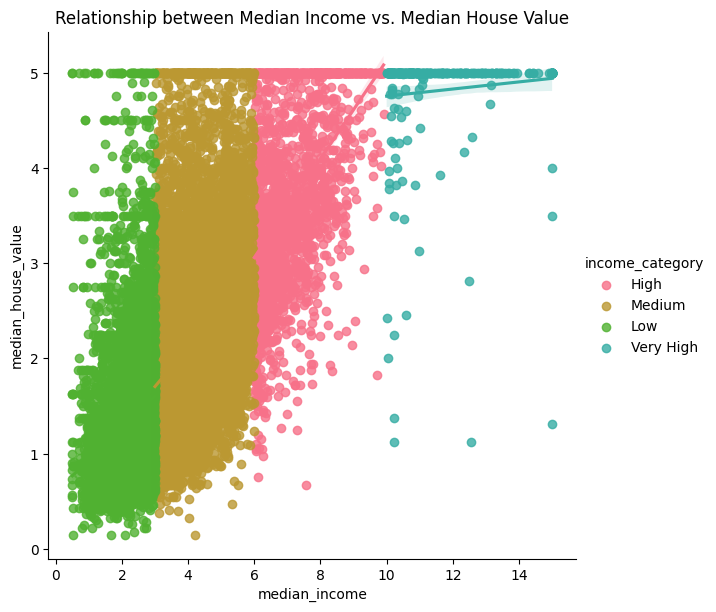

In [19]:
print("=" * 60)
print("ARTIFACT C: VISUALS (SEABORN)")
print("=" * 60)

print("1. REGRESSION VIEW")
print("-" * 30)

print("INCOME CATEGORY DISTRIBUTION:")

income_graph = sns.lmplot(
    data=df_transformed,
    x='median_income',
    y='median_house_value',
    hue='income_category',
    height=6)
plt.title("Relationship between Median Income vs. Median House Value")

print(f"\nINTERPRETATION:")
print(f"- This graph shows that as the median income increases, the overall median house value increases")
print(f"- What's interesting is that the top median house values are more \"populated\" as median income increases")



2. SMALL MULTIPLES
--------------------------------------------------
Relplot
- By isolating based on income categories, we can see some interesting patterns.
- One of which is that as the median income increases, the amount of values (especially lower median_house_value values) decrease


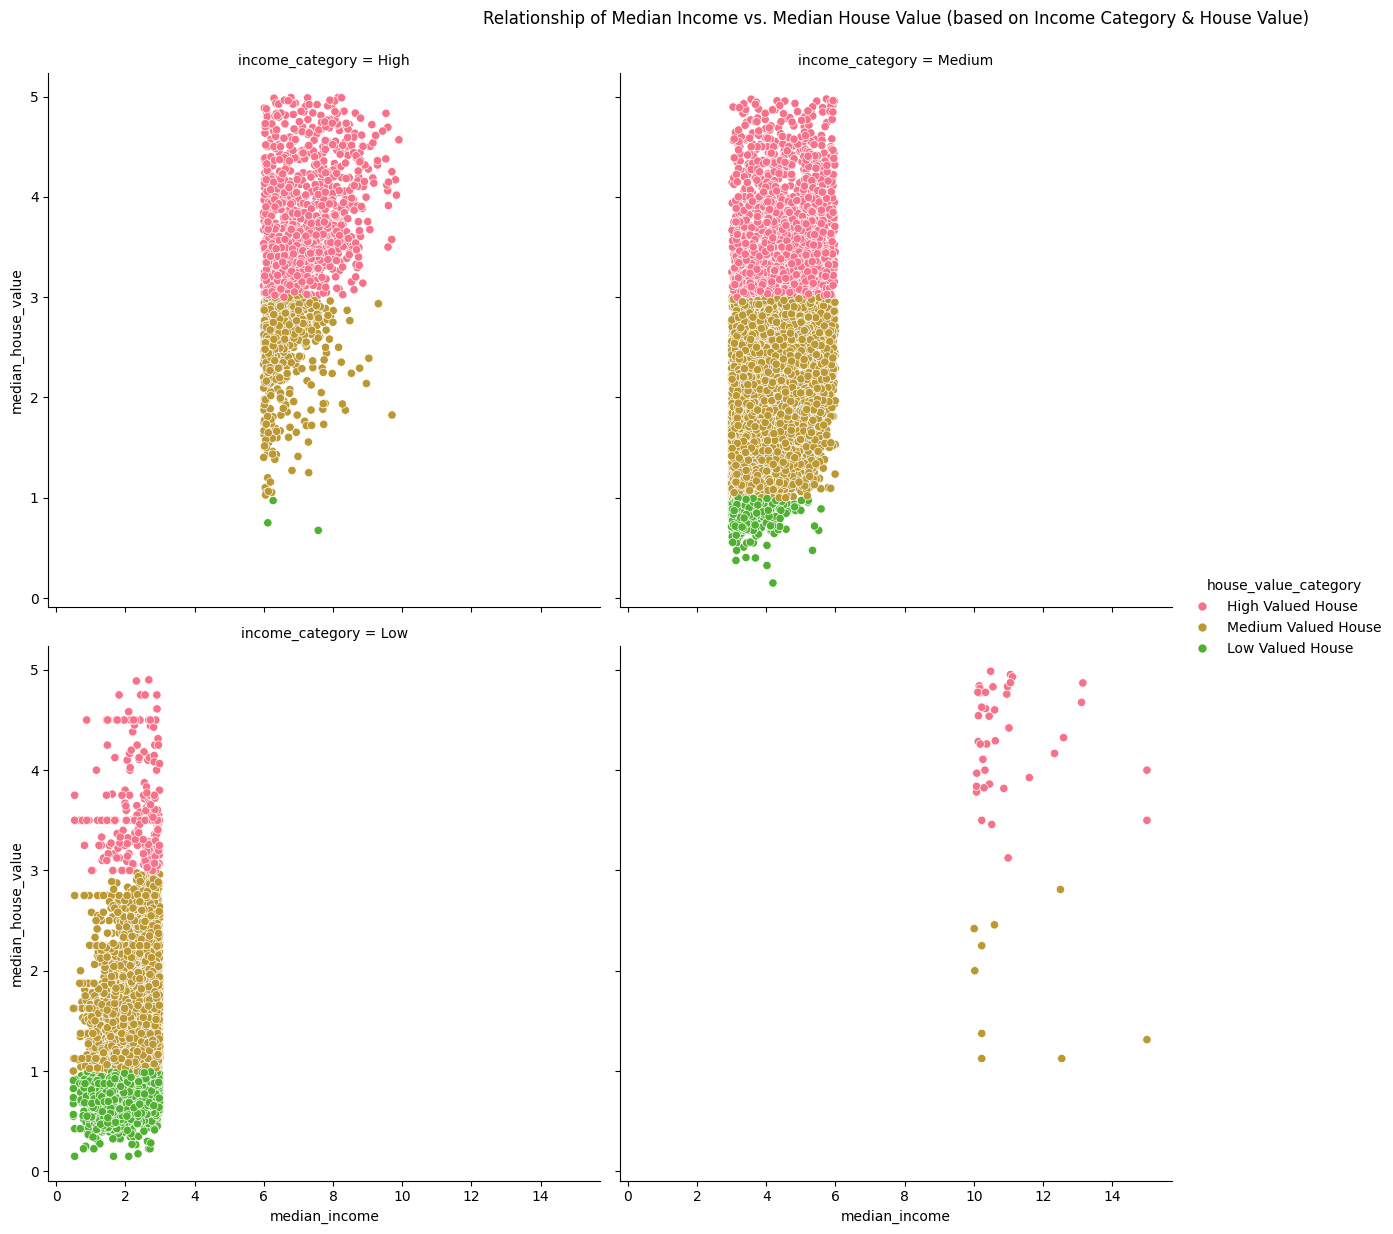

In [20]:
print("\n2. SMALL MULTIPLES")
print("-" * 50)

print("Relplot")

income_graph_one = sns.relplot(
    data=df_transformed,
    x="median_income",
    y="median_house_value",
    col="income_category",
    col_wrap=2,
    height=6,
    hue="house_value_category"
)
plt.title("Relationship of Median Income vs. Median House Value (based on Income Category & House Value)", y=2.15)

print(f"- By isolating based on income categories, we can see some interesting patterns.")
print(f"- One of which is that as the median income increases, the amount of values (especially lower median_house_value values) decrease")


3. CATEGORICAL DISTRIBUTION
-----------------------------------------------------------------
Catplot:
- This graphs shows a clear distinction between the income categories and the median house values
- As seen here, the higher house median values are more populated as the median increases and vice versa
- For instance, for lower median incomes, the higher median house values are pretty isolated
- And for higher median incomes, the lower median house values are the same


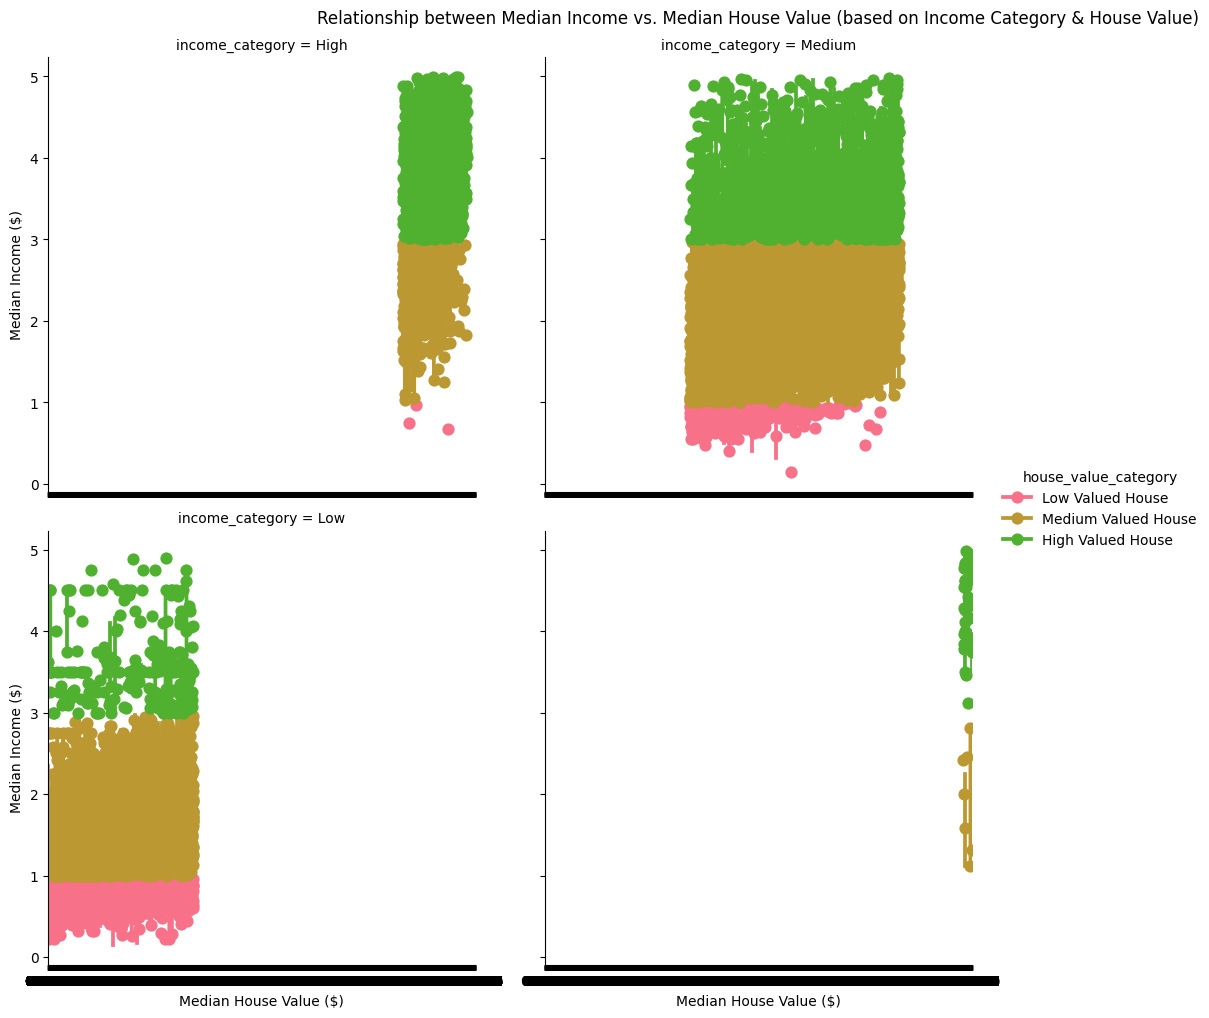

In [23]:
print("\n3. CATEGORICAL DISTRIBUTION")
print("-" * 65)

print("Catplot:")
income_graph_two = sns.catplot(
    data=df_transformed,
    x="median_income",
    y="median_house_value",
    col="income_category",
    col_wrap=2,
    kind="point",
    hue="house_value_category"
)
income_graph_two.set_axis_labels("Median House Value ($)", "Median Income ($)")
plt.title("Relationship between Median Income vs. Median House Value (based on Income Category & House Value)", y=2.15)

print(f"- This graphs shows a clear distinction between the income categories and the median house values")
print(f"- As seen here, the higher house median values are more populated as the median increases and vice versa")
print(f"- For instance, for lower median incomes, the higher median house values are pretty isolated")
print(f"- And for higher median incomes, the lower median house values are the same")

- This graph shows a stacked bar plot of house value categories based on the income category
- It's quite similar to the categorical distribution, but gives specific data
- Basically, it shows the number of low, medium, and high valued houses bought from each income category


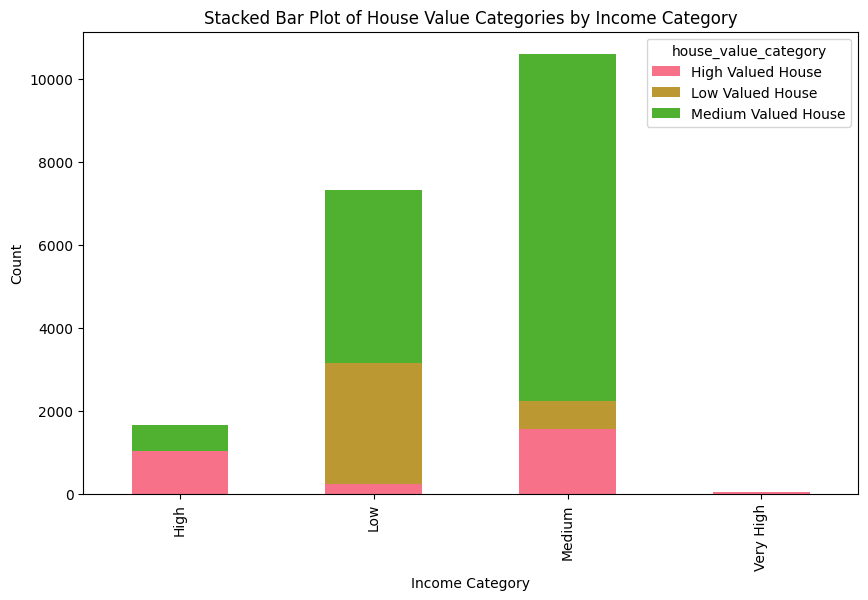

In [24]:
df_counts = df_transformed.groupby(['income_category', 'house_value_category']).size().reset_index(name='count')

df_pivoted = df_counts.pivot_table(
    index='income_category',
    columns='house_value_category',
    values='count',
    aggfunc='sum',
    fill_value=0
)

df_pivoted.plot(
    kind='bar',
    stacked=True,
    figsize=(10, 6)
)

plt.title('Stacked Bar Plot of House Value Categories by Income Category')
plt.xlabel('Income Category')
plt.ylabel('Count')

print(f"- This graph shows a stacked bar plot of house value categories based on the income category")
print(f"- It's quite similar to the categorical distribution, but gives specific data")
print(f"- Basically, it shows the number of low, medium, and high valued houses bought from each income category")

- This graph shoes the Cramer's V Heatmap between income categories and the house value categories...
- As seen here, this show the correlation between the similarity of the two categorical variables.
- Through this, this ranges between a value from 0 to 1, where 0 means no association and 1 means perfect association
- So, income categories paired with income categories usually have higher association and that's the same for house value categories


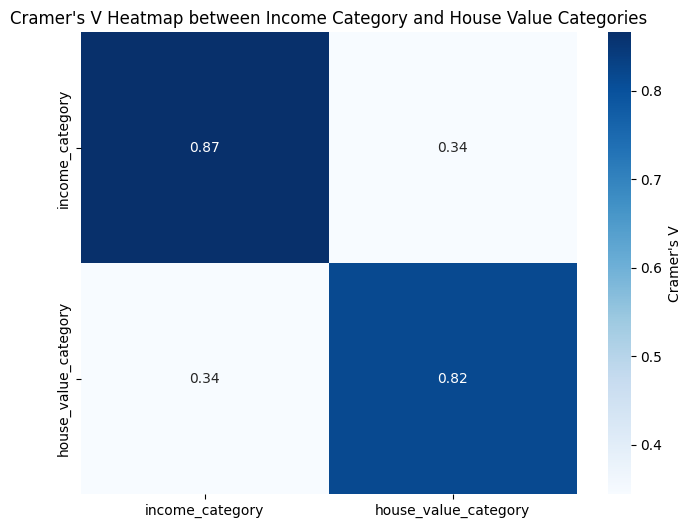

In [25]:
def cramers_v(x, y):
    contingency_table = pd.crosstab(x, y)
    chi2, p, dof, expected = chi2_contingency(contingency_table)
    n = contingency_table.sum().sum()
    return np.sqrt(chi2 / (n * min(contingency_table.shape) - 1))

categorical_columns = ['income_category', 'house_value_category']

cramers_v_matrix = pd.DataFrame(index=categorical_columns, columns=categorical_columns)

for col1 in categorical_columns:
    for col2 in categorical_columns:
        cramers_v_matrix.loc[col1, col2] = cramers_v(df_transformed[col1], df_transformed[col2])

cramers_v_matrix = cramers_v_matrix.astype(float)

plt.figure(figsize=(8, 6))
sns.heatmap(
    cramers_v_matrix,
    annot=True,
    cmap='Blues',
    cbar_kws={'label': 'Cramer\'s V'},
    fmt='.2f'
)
plt.title("Cramer's V Heatmap between Income Category and House Value Categories")

print(f"- This graph shoes the Cramer's V Heatmap between income categories and the house value categories...")
print(f"- As seen here, this show the correlation between the similarity of the two categorical variables.")
print(f"- Through this, this ranges between a value from 0 to 1, where 0 means no association and 1 means perfect association")
print(f"- So, income categories paired with income categories usually have higher association and that's the same for house value categories")

# Artifact D: (Optional) Statistics

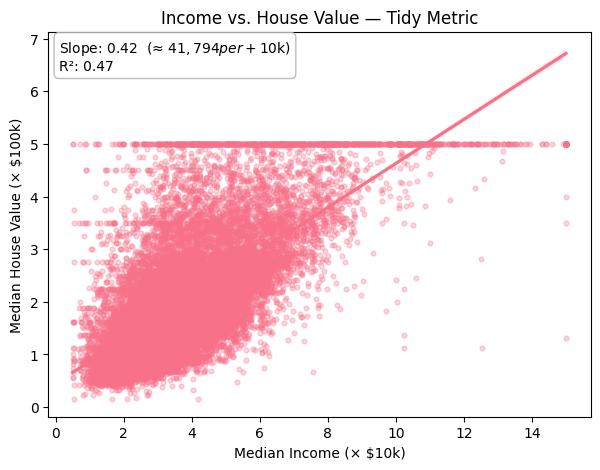

In [22]:

# ARTIFACT D (REPLACED): One tidy metric near the figure

from scipy.stats import linregress

# Predictor (X) and target (Y)
x = df_transformed["median_income"].to_numpy()
y = df_transformed["median_house_value"].to_numpy()

# Safety mask
m = np.isfinite(x) & np.isfinite(y)
res = linregress(x[m], y[m])

slope = res.slope                 # Y units per 1 unit of X
r2    = res.rvalue ** 2           # % variance explained

# Plot with the metric annotated on the figure
fig, ax = plt.subplots(figsize=(7,5))
sns.regplot(
    x="median_income",
    y="median_house_value",
    data=df_transformed,
    ax=ax,
    scatter_kws={"alpha": 0.3, "s": 12},
    line_kws={}
)

ax.set_title("Income vs. House Value — Tidy Metric")
ax.set_xlabel("Median Income (× $10k)")
ax.set_ylabel("Median House Value (× $100k)")

# Annotate slope and R² near the plot
annotation = (
    f"Slope: {slope:.2f}  (≈ ${slope*100_000:,.0f} per +$10k)\n"
    f"R²: {r2:.2f}"
)
ax.text(
    0.02, 0.98, annotation,
    transform=ax.transAxes,
    va="top", ha="left",
    fontsize=10,
    bbox=dict(boxstyle="round,pad=0.35", facecolor="white", alpha=0.85, edgecolor="0.7")
)

plt.show()


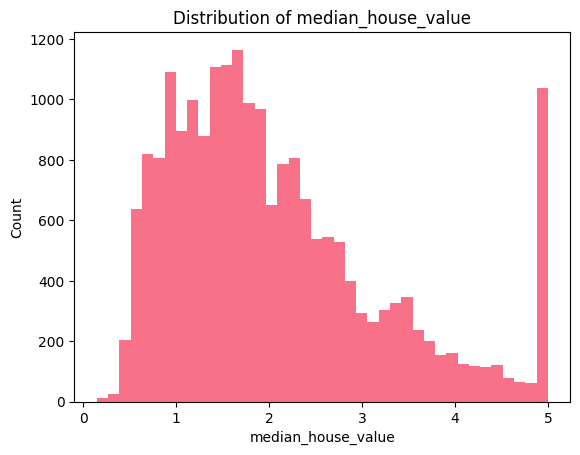

ARTIFACT D: LINEAR REGRESSION (median_income to median_house_value)
Units:
- X (median_income): per +1.0 = +$10,000
- Y (median_house_value): per +1.0 = +$100,000

Slope      : 0.4179  (≈ $41,794 change in median house value per +$10,000 income)
Intercept  : 0.4509  (≈ $45,086 when income = $0)
R          : 0.6881
R²         : 0.4734
p-value    : 0.000e+00
Std. Error : 0.0031

INTERPRETATION:
- There is a positive relationship between income and house value with moderate explanatory power (R² = 0.47).
- Each +$10,000 increase in median income is associated with an average house value change of ≈ $41,794.
- Note: values are top-coded at $500,000, which can compress the fit at the high end and slightly understate the slope.


In [26]:
#histogram
numeric_target = "median_house_value" if "median_house_value" in df.columns else "median_income"

ax = df[numeric_target].plot(kind="hist", bins=40)
ax.set_title(f"Distribution of {numeric_target}")
ax.set_xlabel(numeric_target)
ax.set_ylabel("Count")
ax.grid(False)
plt.show()

from scipy.stats import linregress
import numpy as np

# Predictor and target (units per your Data Card)
# X: median_income in tens of thousands of dollars ($10k)
# Y: median_house_value in hundreds of thousands of dollars ($100k)
x = df_transformed['median_income']
y = df_transformed['median_house_value']

# Safety: drop any non-finite values (should be none after earlier fixes)
mask = np.isfinite(x) & np.isfinite(y)
res = linregress(x[mask], y[mask])

slope = res.slope
intercept = res.intercept
r_value = res.rvalue
p_value = res.pvalue
stderr = res.stderr
r2 = r_value ** 2

print("=" * 60)
print("ARTIFACT D: LINEAR REGRESSION (median_income to median_house_value)")
print("=" * 60)
print("Units:")
print("- X (median_income): per +1.0 = +$10,000")
print("- Y (median_house_value): per +1.0 = +$100,000\n")

print(f"Slope      : {slope:.4f}  "
      f"(≈ ${slope*100_000:,.0f} change in median house value per +$10,000 income)")
print(f"Intercept  : {intercept:.4f}  "
      f"(≈ ${intercept*100_000:,.0f} when income = $0)")
print(f"R          : {r_value:.4f}")
print(f"R²         : {r2:.4f}")
print(f"p-value    : {p_value:.3e}")
print(f"Std. Error : {stderr:.4f}\n")

# Brief interpretation
direction = "positive" if slope > 0 else "negative"
strength = ("very strong" if r2 >= 0.70 else
            "moderate" if r2 >= 0.30 else
            "weak")

print("INTERPRETATION:")
print(f"- There is a {direction} relationship between income and house value with {strength} explanatory power (R² = {r2:.2f}).")
print("- Each +$10,000 increase in median income is associated with an average house value change of "
      f"≈ ${slope*100_000:,.0f}.")
print("- Note: values are top-coded at $500,000, which can compress the fit at the high end and slightly understate the slope.")

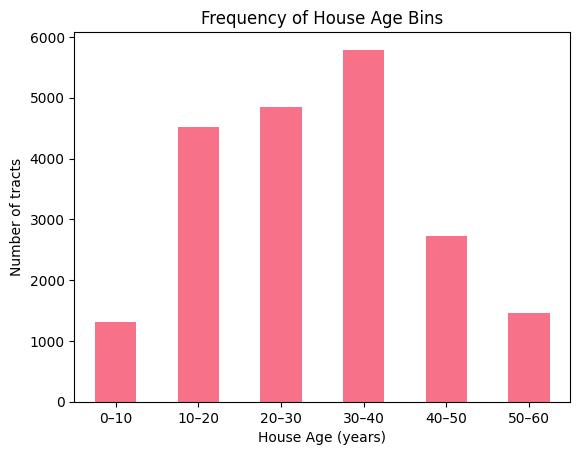

In [27]:
#frequency chart
bins   = [0, 10, 20, 30, 40, 50, 60]
labels = ["0–10", "10–20", "20–30", "30–40", "40–50", "50–60"]

age_bins = pd.cut(df["housing_median_age"], bins=bins, labels=labels, right=False, include_lowest=True)
freq = age_bins.value_counts().sort_index()

ax = freq.plot(kind="bar")
ax.set_title("Frequency of House Age Bins")
ax.set_xlabel("House Age (years)")
ax.set_ylabel("Number of tracts")
ax.tick_params(axis="x", rotation=0)  # keep ticks readable
ax.grid(False)
plt.show()

# Artifact E: Reproduceability